In [ ]:
#pip install python-craigslist

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Dependencies
from craigslist import CraigslistHousing
import timeit, os
from tqdm import tqdm
import pickle
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import time
import pandas as pd
import missingno
import re
import json
from pprint import pprint
from datetime import datetime, timedelta, timezone

from urls_list import * #where all urls and paths are saved
from config import *
from harvesine_distance import harvesine_distance


# Extract

###  Craigslist api call to extract the listing url and basic information

In [ ]:
##Initially we scrape all 3000 in entire toronto. Then, we scrape on a daily posting basis from craiglist while building app
#https://toronto.craigslist.org/search/apa?bundleDuplicates=1&availabilityMode=0&sale_date=all+dates

In [ ]:
def craigs_list_api_call():
    
    cl_tor_housing = CraigslistHousing(site='toronto',
                             filters={'bundle_duplicates': 1})

    #If geotagged=True, the results will include the (lat, lng) in the 'geotag' attrib (this will make the process a little bit longer).
    craiglist_housing = []

    start = timeit.timeit()
    for result in tqdm(cl_tor_housing.get_results(sort_by='newest', geotagged=True)):
        craiglist_housing.append(result)
    end = timeit.timeit()
    print(f"Time elapsed is {end - start}")
    return craiglist_housing

#craiglist_housing = craigs_list_api_call()

In [ ]:
#with open('craiglist_housing.pkl', 'wb') as f:
    #pickle.dump(craiglist_housing, f)

with open('craiglist_housing.pkl', 'rb') as f:
    craiglist_housing = pickle.load(f)

###  Scraping the craigslist posting data using the urls obtained through API call

In [ ]:
def instatiate_driver():
    #########################################################################################
    #Instatiate Selenium driver
    #Returns the handle object
    #########################################################################################
    chrome_options = webdriver.ChromeOptions()
    CHROMEDRIVER_PATH = executable_path
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(executable_path=CHROMEDRIVER_PATH, options=chrome_options)
    return driver

In [ ]:
def craigs_list_scrape(craigs_list_post_docs):
    #Instatiate the selenium driver
    driver = instatiate_driver()
    error_list = []
    

    craigs_list_post_docs_cp = craigs_list_post_docs.copy()
    for post in tqdm(craigs_list_post_docs_cp):

        #Visit the url
        driver.get(post['url'])

        #Separate Try Except to handle each cases separately
        #Apartment feature(Some extra feature beside the title)
        try:
            apartment_feature = driver.find_element_by_css_selector('span[class="postingtitletext"] span[class="housing"]').text
        except:
            #print(post['id'])
            error_list.append({post['id']:'apartment_feature'})
            apartment_feature = None
        finally:
            post['apartment_feature'] = apartment_feature

        #First image if present   
        try:
            image = None
            if post['has_image']:
                image = driver.find_element_by_css_selector('div[class="gallery"]').find_element_by_css_selector('img').get_attribute('src')
        except:
            print(post['id'])
            error_list.append({post['id']:'image'})
        finally:
            post['has_image'] = image

        #Body of the post  
        try:
            posting = driver.find_element_by_id("postingbody").text
        except:
            print(post['id'])
            error_list.append({post['id']:'postingbody'})
            posting = None
        finally:
            post['posting'] = posting

        #Attributes      
        try:
            attributes = [elem.text for elem in driver.find_elements_by_css_selector('p[class="attrgroup"]  span')]
        except:
            print(post['id'])
            error_list.append({post['id']:'attributes'})
            attributes = []
        finally:
            post['attributes'] = attributes
            
        time.sleep(1)
            
    driver.quit()       
    return craigs_list_post_docs_cp
    

In [ ]:
#craiglist_housing_enriched = craigs_list_scrape(craiglist_housing)

In [ ]:
#with open('craiglist_housing_enriched.pkl', 'wb') as f:
    #pickle.dump(craiglist_housing_enriched, f)

with open('craiglist_housing_enriched.pkl', 'rb') as f:
    craiglist_renting_data = pickle.load(f)

---
---
---

### Check https://data.torontopolice.on.ca/datasets/mci-metadata/geoservice to see what input we need to give

In [9]:
id_value_dict = {row[1][0]:row[1][1] for row in pd.read_csv('MCI_Metadata.csv')[['ObjectId', 'Fields']].iterrows()}
value_id_dict = {id_value_dict[key]:key for key in id_value_dict}

`MCI Data` consists of assault, auto theft, break and enter, robbery and theft over
- We use `https://data.torontopolice.on.ca/datasets/mci-metadata/geoservice` to store all the data available (2014-2019) only

In [10]:
def batch_retrieve(arcgis_mci):
    #Takes url
    #API call
    #Gets response
    #Extract relevant info
    #Returns the no of records
    
    try:
        response = requests.get(arcgis_mci).json()
        records = [entry['attributes'] for entry in response['features']]

    except Exception as e:
        print("Arcgis mci url changed!")
    
    return records

def retrieve():
    #This function calls batch retrieve function with different URLs made with non-overlapping start - end date intervals
    #We have to do this because of the MCI data api behavious of providing only 2000 records at a time
    #The response is appended to a json file
    
    Data_DF = pd.DataFrame()
    
    
    start = datetime.fromisoformat('2014-01-01')
    while start < datetime.fromisoformat('2019-12-31') :
        end = start+timedelta(days=10) if start+timedelta(days=10) <= datetime.fromisoformat('2019-12-31') else datetime.fromisoformat('2019-12-31')
        start_date = start.strftime("%Y-%m-%d")
        end_date = end.strftime("%Y-%m-%d")
        arcgis_mci=f"https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_to_2019/FeatureServer/0/query?where=reporteddate%20%3E%3D%20TIMESTAMP%20'{start_date}%2000%3A00%3A00'%20AND%20reporteddate%20%3C%3D%20TIMESTAMP%20'{end_date}%2000%3A00%3A00'&outFields=Index_,occurrencedate,reporteddate,premisetype,offence,MCI,Division,Neighbourhood,Long,Lat,reportedyear&returnGeometry=false&orderByFields=reporteddate ASC&outSR=&f=json"
        records = batch_retrieve(arcgis_mci)
        Data_DF=pd.concat([Data_DF, pd.DataFrame(records)])
        start = end+timedelta(days=1)
        
    return Data_DF

``MCI_DF = retrieve()``

Convert occurrencedate and reporteddate to the standard time format
Both are in UTC timestamp format which is the total millisec from 1970-01-01
``MCI_DF[['occurrencedate','reporteddate']] = MCI_DF[['occurrencedate','reporteddate']].apply(lambda x: [datetime.utcfromtimestamp(item//1000).strftime("%Y-%m-%d") for item in x])``

``with open('MCI_toronto_data.pkl', 'wb') as f:
    pickle.dump(MCI_DF,f)``

In [11]:
with open('MCI_toronto_data.pkl', 'rb') as f:
    MCI_DF = pickle.load(f)

In [12]:
MCI_DF.head()

,Index_,occurrencedate,reporteddate,premisetype,offence,MCI,Division,Neighbourhood,Long,Lat,reportedyear
0,399,2014-01-01,2014-01-01,House,Assault,Assault,D11,Little Portugal (84),-79.438225,43.648006,2014
1,428,2014-01-01,2014-01-01,Outside,Assault Bodily Harm,Assault,D43,Woburn (137),-79.235268,43.757725,2014
2,429,2014-01-01,2014-01-01,Apartment,Assault,Assault,D31,York University Heights (27),-79.500000,43.761066,2014
3,430,2014-01-01,2014-01-01,Commercial,B&E W'Intent,Break and Enter,D41,Dorset Park (126),-79.281075,43.765804,2014
4,414,2014-01-01,2014-01-01,House,Assault,Assault,D41,Kennedy Park (124),-79.262123,43.722282,2014


---
---
---

# Transform

### Initial form of data after scraping

In [13]:
DF = pd.DataFrame(craiglist_renting_data)
DF.head()

,id,repost_of,name,url,datetime,last_updated,price,where,has_image,geotag,deleted,apartment_feature,posting,attributes
0,7175656775,None,2 Bedrooms Apartment for Rent - 1350 Danforth ...,https://toronto.craigslist.org/tor/apa/d/scarb...,2020-08-11 17:00,2020-08-11 17:00,"$1,350",1350 Danforth Road,https://images.craigslist.org/00F0F_l6VTmsBVGh...,"(43.7464, -79.2323)",False,/ 2br -,Please view our available units by clicking on...,"[2BR / 1Ba, cats are OK - purrr, dogs are OK -..."
1,7175641724,4905301368,☎2 Room+Separate Reception @Etobicoke/Miss☎,https://toronto.craigslist.org/tor/off/d/2-roo...,2020-08-11 16:59,2020-08-11 16:59,"$1,599",Skymark Ave,https://images.craigslist.org/00q0q_hhCvFpP61t...,"(43.663625, -79.593099)",False,None,*SPECIAL OFFER - $200 off the monthly rent for...,[]
2,7175652366,7156890373,87 Peter - Slate - 1bed Sept 1,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:53,2020-08-11 16:53,"$2,000",downtown,https://images.craigslist.org/01212_1tx3p0rlYW...,"(43.646603, -79.392271)",False,/ 1br - 538ft2 -,87 Peter St –#3311 Slate – 1bed/1bath - 538 Sq...,"[1BR / 1Ba, 538ft2, available sep 1, cats are ..."
3,7175652126,7156846968,Harbour Plaza! 1Bed/1Bath +media area - September,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:52,2020-08-11 16:52,"$2,250",Waterfront,https://images.craigslist.org/00Q0Q_huAI9VgN8a...,"(43.641093, -79.380324)",False,/ 1br - 595ft2 -,$2250 - 88 Harbour #2405 – 1Bed/1Bath (media a...,"[1BR / 1Ba, 595ft2, available sep 1, condo, w/..."
4,7175651860,6808310702,The Eglinton / Redpath -studio,https://toronto.craigslist.org/tor/apa/d/toron...,2020-08-11 16:52,2020-08-11 16:52,"$1,750",125 Redpath Ave,https://images.craigslist.org/00J0J_3SYJ5EqHxl...,"(43.707766, -79.392611)",False,/ 1br - 359ft2 -,The Eglinton- Maxwell #2711 -359 SqFt Studio $...,"[1BR / 2Ba, 359ft2, available aug 14, condo, w..."


### Remove Duplicates and unreliable data
- All duplicated data are removed
- Dont consider empty postings
- Drop all those rows which don't have both 'geotag' and 'where'

In [14]:
## Check for duplicates in the dataset

In [15]:
duplicates = DF[DF.duplicated(DF.columns[:-1], keep=False)] #Duplicates cannot hash list
DF.drop_duplicates(subset=DF.columns[:-1], keep="first", inplace=True)
#Now id is unique
DF[DF.duplicated(DF.columns[0], keep=False)]


,id,repost_of,name,url,datetime,last_updated,price,where,has_image,geotag,deleted,apartment_feature,posting,attributes


(21, 14)

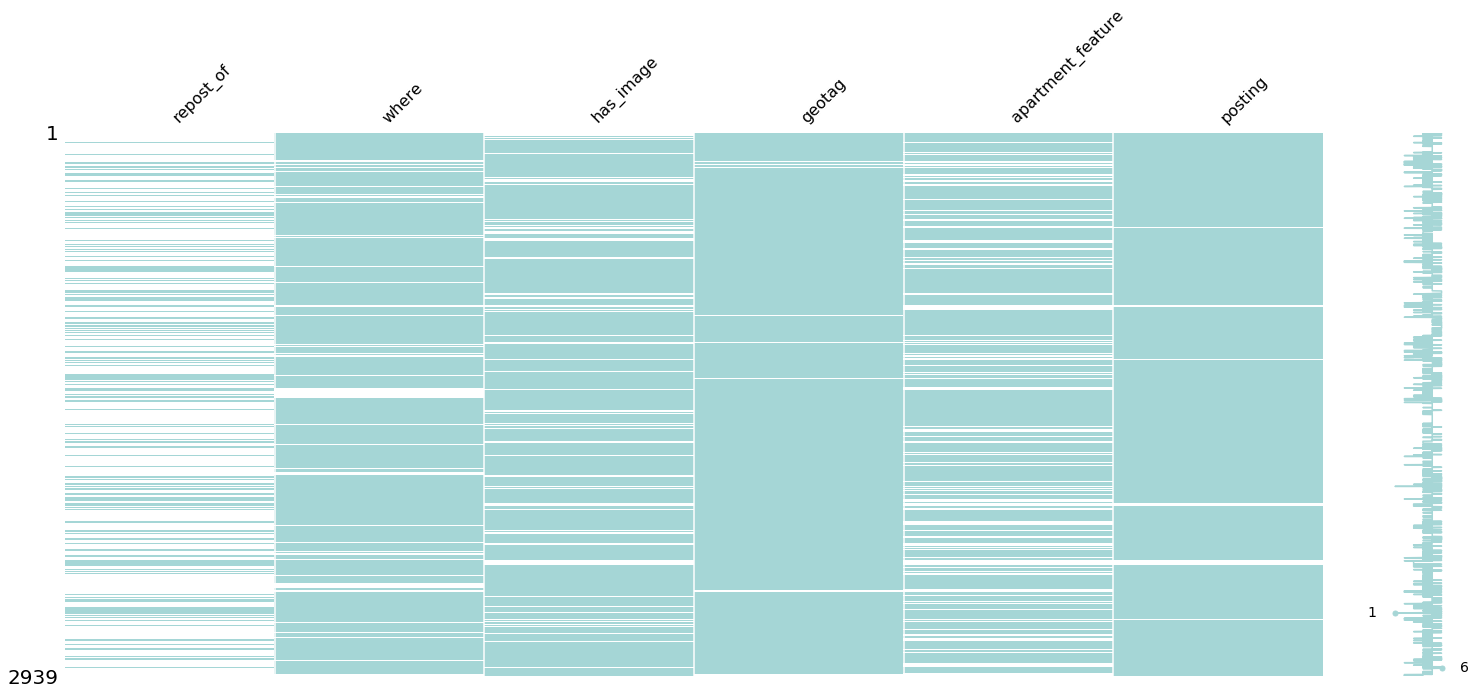

In [16]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.65,0.84,0.84))
#Dont consider empty postings
DF.dropna(subset=['posting'], inplace=True)

#Location:- Coming to whereabouts, in most of the cases, we have geotag. Some of the cases which doesn't have geotag,
#we have "where". Check below.
DF[DF[['geotag', 'where']].apply(lambda x: (x['where'] is not None) and  (x['geotag'] is None) , axis=1)].shape
#We need to drop all those rows which don't have both
DF.dropna(subset=['where', 'geotag'], how='all', inplace=True)

## Deive new Features
- Combine the "attributes", "apartment_feature", "posting" together as "text" column for string search using regex to derive new features
- New features derived are
    - sf - Square Feet : (int or None) Based on ft2|SqFt in the text data
    - br - Bed Room: (float or None) Number of bedrooms, based on what is preceding BR 
    - ba - Bath: (float or None) Number of bath, based on what is preceding Ba
    - cats_allowed - True or False, based on the presence of 'cats are OK - purrr'
    - dogs are OK - wooof - True or False, based on the presence of 'dogs are OK - wooof'
    - Type - Type of the housing 1 out of ``['condo', 'house', 'apartment', 'suite', 'townhouse', 'loft', 'duplex',
       'flat', 'cottage', 'land']`` or ``None``
    - furnished - True/Flase/None - based on the presense of (un|non)(-) furnished strings or nothing
    

```unique_attributes = set()
for entry in DF['attributes']:
    unique_attributes = unique_attributes.union(set(entry))
unique_attributes```  

In [17]:
#Convert list to string
DF['attributes'] = DF['attributes'].map(lambda x: ' '.join(x))
#Convert the apartment feature none to ''(string)
DF['apartment_feature'].fillna(value=' ', inplace=True)#A string val
#Combine the "attributes", "apartment_feature", "posting" together as "text" column
DF["text"] = DF.apply(lambda x: x["attributes"]+x["apartment_feature"]+x["posting"], axis=1)
#Use DF["text"] for all further extractions 



In [18]:
def extract(s):
    #DF['Text'] comes here as the input
    #Square Feet
    sf_found = re.findall('(\d+) *(ft2|SqFt)', s)
    sf =  (None if not sf_found else int(sf_found[0][0]))

    #Bed Room
    br_found = re.findall('(\d){0,1}(.5){0,1} *BR', s)
    br = float(''.join(br_found[0])) if  br_found and ''.join(br_found[0]) else None #To handle ('','','') situation
            
    
    #Bath
    ba_found = re.findall('(\d){0,1}(.5){0,1}(\+){0,1} *B[aA]',s)
    ba = float(re.sub('[^\d]', '', ''.join(ba_found[0]))) if  ba_found and re.sub('[^\d]', '', ''.join(ba_found[0])) else None
    
    
    #'cats are OK - purrr'
    cats_allowed = (True if re.findall('cats are OK - purrr', s) else False)
    
    #'dogs are OK - wooof'
    dogs_allowed = (True if re.findall('dogs are OK - wooof', s) else False)
    
    #Check the type of the commodity
    re.sub(r'[\n\.,!/?()]', ' ', DF['text'].iloc[0].lower()) #Remove unnecessary chars. We need to capture apartment\ also as word apartment
    cleaned_s = re.sub('[\n\\.,!\/?]', ' ', s)
    found_type = re.findall(r"\b(townhouse|loft|land|house|flat|duplex|condo|cottage|suite)\b", cleaned_s, flags=re.IGNORECASE) 
    Type = (None if not found_type else found_type[0].lower())
    #Though apartment is a generic term, some people mention the type as apartment, we are going to take that as the last priority
    #if nothing else is mentioned
    if not Type:
        found_type = re.findall(r"\bapartment\b", cleaned_s, flags=re.IGNORECASE)
        Type = (None if not found_type else found_type[0].lower())
        
    #Furnished or Unfurnished checks
    found_un = re.findall('(non|un)-*(?=furnished)', s , flags=re.IGNORECASE)
    furnished = False
    if not found_un:
        #furnished = None #Nothing found
        found_furnished = re.findall('furnished', s , flags=re.IGNORECASE)
        furnished = (None if not found_furnished else True)
    
    return [sf,br,ba, cats_allowed, dogs_allowed, Type, furnished]

In [19]:
DF[['sf', 'BR', 'Ba','cats_allowed', 'dogs_allowed', 'Type', 'furnished']] = pd.DataFrame(DF['text'].map(lambda x : extract(x)).to_list(), index=DF.index)

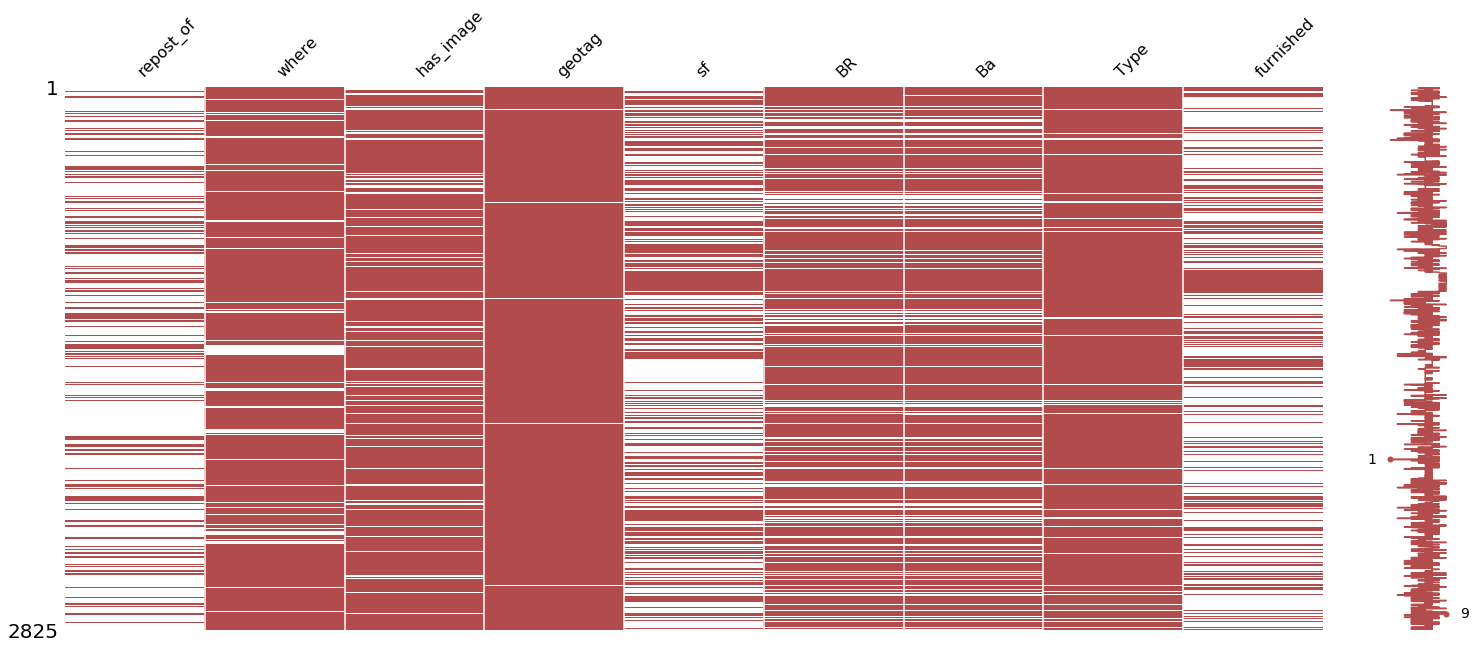

In [20]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.7,0.3,0.3))


### Geocode the address to lat long

In [21]:
#Dictionary with index and address
def geocode(addresses):
    #Input: a dictionary with key as index and value as address
    #Output: a dictionary with key as index and value as (lat, long) tuple
    lat_long = {}
    for index in addresses:
        try:
            url = geocode_api+f'?address={addresses[index]}'+f'&key={google_api}'
            url = re.sub(' +', '%20', url)
            response = requests.get(url)
            if response.ok:
                content = response.json()
                lat_long[index]=tuple(content['results'][0]['geometry']['location'].values())
            else:
                lat_long[index]=None
        except Exception as e:
            print(e)
            lat_long[index]=None
    return lat_long

In [22]:
addresses = DF[DF['geotag'].isnull()]['where'].to_dict()

```lat_long = geocode(addresses)```

In [24]:
#lat_long = geocode(addresses)

In [25]:
## Replace the Null geocodes with the geocodes retrieved from the address
DF.loc[lat_long.keys(), 'geotag'] = DF.loc[lat_long.keys()].index.map(lat_long)

In [26]:
#Now no missing values in geocode
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
missingdata_cols

['repost_of', 'where', 'has_image', 'sf', 'BR', 'Ba', 'Type', 'furnished']

### Postal codes based on lat long

In [54]:
#https://maps.googleapis.com/maps/api/geocode/json?latlng=40.714224,-73.961452&key=YOUR_API_KEY
#reverse_geocode_api = 'https://maps.googleapis.com/maps/api/geocode/json'

#Dictionary with index and address
def reverse_geocode(loc):
    #Input: tuple - (lat, long)
    #Output: string - Postal Code
    lat, long = loc
    postal_code = None
    try:
        url = reverse_geocode_api+f'?latlng={lat},{long}&result_type=postal_code'+f'&key={google_api}'
        url = re.sub(' +', '%20', url)
        #print(url)
        response = requests.get(url)
        if response.ok:
            content = response.json()
            postal_code = content['results'][0]["address_components"][0]['long_name'] if 'postal_code' in content['results'][0]\
["address_components"][0]['types'] else None
    except Exception as e:
        print(e)
    return postal_code   

In [52]:
#DF['postal_code'] = DF['geotag'].map(lambda x: reverse_geocode(x))
#DF[DF['postal_code'].notnull()].shape
#DF.shape
#Discarding those 6 items which doesn't have postal code
#DF.drop(index=DF[DF['postal_code'].isnull()].index, inplace=True)

``DF['postal_code'] = DF['geotag'].map(lambda x: reverse_geocode(x))``

``DF[DF['postal_code'].notnull()].shape``

``DF.shape``

``#Discarding those 7 items which doesn't have postal code``

``DF.drop(index=DF[DF['postal_code'].isnull()].index, inplace=True)``

In [62]:
## Some Florida postal codes in the dataset. Remove them
#DF['postal_code'][DF['postal_code'].map(lambda x : re.findall('^[\d].*', x)[0] if re.findall('^[\d].*', x) else None).notnull()]  


In [68]:
Florida_Zipcodes = DF['postal_code'][DF['postal_code'].map(lambda x : re.findall('^[\d].*', x)[0] if re.findall('^[\d].*', x) else None).notnull()].index    
#DF.drop(index=Florida_Zipcodes, inplace=True)

### Save standalone craigslist dataset

In [71]:
#with open('craiglist_standalone.pkl', 'wb') as f:
    #pickle.dump(DF, f)

In [75]:
with open('craiglist_standalone.pkl', 'rb') as f:
    DF = pickle.load(f)

### Toronto postal codes

In [81]:
postal_code_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

In [106]:
postal_code_data = postal_code_data[postal_code_data['Borough'].map(lambda x: None if not re.findall('toronto', x, flags=re.IGNORECASE) else re.findall('toronto', x, flags=re.IGNORECASE)[0]).notnull()]
tor_postal_codes=postal_code_data['Postal Code'].to_list()

### Filter rental data based on postal code to extract just Toronto area (Initial data set has greater toronto area)

In [118]:
DF['Toronto'] = DF['postal_code'].map(lambda x: 'Toronto' if x.split()[0] in tor_postal_codes else None)

In [119]:
craiglist_toronto = DF[DF['Toronto'].notnull()].copy()
craiglist_toronto.drop('Toronto', axis=1, inplace=True)

### Connect tables Housing and MCI meaningfully!

**``Write a function that finds the distance between each ``**

In [ ]:
loc1 = DF.geotag[0]
loc2 = MCI_DF.iloc[0]['Lat'], MCI_DF.iloc[0]['Long']
date_posted = datetime.strptime(DF.datetime[0], "%Y-%m-%d %H:%M")
km = 3
years = 3
time_threshold = years*365
#(harvesine_distance(loc1, (x['Lat'], x['Long']))<=km)
MCI_DF.apply(lambda x: date_posted-x[, axis=1)





In [ ]:
MCI_DF.


- Steps remaining
    - API call to google to get lat long for the missing value lat longs (from address)
    - Identify all the neighbourhoods in the MCI data
    - For the rental posting, find the nearest neighbourhood in the MCI data
    
- Cleaning and making everything in specific data types

- Data dumping to postgres/mongoDB 

- If there is time, make a flask with a scheduler to scrape and update to db the delta
